<h1>YOLO</h1>

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from ast import literal_eval
#from pydicom import dcmread, read_file
import matplotlib.pyplot as plt
import cv2
import shutil
#from numba import njit

In [2]:
df = pd.read_csv('class.csv')
df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [6]:
print('originalmente hay: ',str(df.shape[0]))

originalmente hay:  30227


Eliminemos las quetienen Not normal pues queremos identificar las que tienen opacidad y las sanas

In [13]:
condicion = (df['class'] == "No Lung Opacity / Not Normal")
df = df.drop(df[condicion].index)

In [14]:
df.to_csv('class.csv', index=False)

In [28]:
df = df.sort_values(by=['class','patientId'])
df = df.drop_duplicates()
df.to_csv('class.csv', index=False)

In [29]:
print("solo quedan:",str(df.shape[0]))

solo quedan: 14863


In [43]:
df2= pd.read_csv('labels.csv')
df2.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [51]:
ptid1=list(df['patientId'])
x=list(df2['x'])
y=list(df2['y'])
w=list(df2['width'])
h=list(df2['height'])

In [56]:
B=[]
for im in tqdm(ptid1):
    indices = df2.loc[df2['patientId'] ==im].index
    bbs=[]
    if df2.iloc[indices[0], df2.columns.get_loc('Target')]:
        for i in indices:
            bb=[x[i],y[i],w[i],h[i]]
            bbs.append(bb)
    B.append(bbs)

100%|████████████████████████████████████| 14863/14863 [00:28<00:00, 517.87it/s]


In [60]:
df['bboxes']=B
df.to_csv('class.csv', index=False)

Trabajando con el archivo generado

In [61]:
df = pd.read_csv('class.csv')
conteo_clase = df['class'].value_counts()
print("\nConteo por la columna 'class':")
print(conteo_clase)


Conteo por la columna 'class':
class
Normal          8851
Lung Opacity    6012
Name: count, dtype: int64


In [33]:
def xyhw_yolo(bbox):
    xc = (bbox[0] + bbox[2] / 2) 
    yc = (bbox[1] + bbox[3] / 2) 
    wn = bbox[2] 
    hn = bbox[3] 
    return [xc,yc,wn,hn]

In [23]:
root="/home/jair/COVID/rsna/ds_original/"

In [27]:
df = pd.read_csv('class_opacity.csv')
imagenes=list(df['patientId'])

In [108]:
for imagen in tqdm(imagenes):
    dicom=dcmread(root+imagen+'.dcm')
    img=dicom.pixel_array
    pixel_min = np.min(img)
    pixel_max = np.max(img)
    pixel_array = ((img - pixel_min) / (pixel_max - pixel_min) * 255).astype(np.uint8)
    img = cv2.resize(pixel_array, (640, 640))
    plt.imsave('/home/jair/COVID/rsna/ds_modif/images/'+imagen+".png",img, cmap='gray')

100%|█████████████████████████████████████| 14863/14863 [30:55<00:00,  8.01it/s]


In [28]:
df = pd.read_csv('class_opacity.csv')
imagenes=list(df['patientId'])
bboxes=list(df['bboxes'])
#bbsn=list(df['bboxes yolo 1024'])

In [34]:
B=[]
for index,imagen in tqdm(enumerate(imagenes)):
    dicom=dcmread(root+imagen+'.dcm')
    img=dicom.pixel_array
    pancho = 640 / img.shape[0]
    palto = 640 / img.shape[1]
    bbn=[]
    for bb in literal_eval(bboxes[index]):
        xn=bb[0]*pancho
        yn=bb[1]*palto
        wn=bb[2]*pancho
        hn=bb[3]*palto
        new=xyhw_yolo([xn,yn,wn,hn])
        print(new)
        #bbn.append(new)
    #B.append(bbn)
    break

0it [00:00, ?it/s]

[250.625, 348.125, 106.25, 298.75]
[458.125, 360.0, 91.25, 251.25]


In [35]:
B=[]
for index,imagen in tqdm(enumerate(imagenes)):
    bbn=[]
    for bb in literal_eval(bboxes[index]):
        new=xyhw_yolo(bb)
        bbn.append(new)
    B.append(bbn)
    break

0it [00:00, ?it/s]

[401.0, 557.0, 170.0, 478.0]
[733.0, 576.0, 146.0, 402.0]


In [11]:
df['bboxes yolo 1024']=B
df.to_csv('class.csv', index=False)

In [23]:
root='/home/jair/COVID/rsna/labels/'
for index , imagen in tqdm(enumerate(imagenes)):
    ruta=root+imagen+'.txt'
    for bb in literal_eval(bbsn[index]):
        with open(ruta, 'a') as archivo:
            archivo.write('0 '+str(bb[0])+' '+str(bb[1])+' '+str(bb[2])+' '+str(bb[3])+'\n')    

6012it [00:00, 7453.18it/s]


In [25]:
O=pd.read_csv('class_opacity.csv')
S=pd.read_csv('class_sano.csv')
opacities=O['patientId']
sanos=S['patientId']

In [3]:
int(len(opacities)*0.7)

4208

In [ ]:
ro='/home/jair/COVID/rsna/ds_original/'
rd='/home/jair/COVID/rsna/datasets/rsna/images/'

for index,img in tqdm(enumerate(opacities)):
    dicom=dcmread(ro+img+'.dcm')
    imag=dicom.pixel_array
    pixel_min = np.min(imag)
    pixel_max = np.max(imag)
    pixel_array = ((imag - pixel_min) / (pixel_max - pixel_min) * 255).astype(np.uint8)
    if index < int(len(opacities)*0.7):
        plt.imsave(rd+'train/'+img+".png",pixel_array, cmap='gray')
    if index >=int(len(opacities)*0.7) and  index <int(len(opacities)*0.7)+int(len(opacities)*0.2):
        plt.imsave(rd+'validation/'+img+".png",pixel_array, cmap='gray')
    if index >= int(len(opacities)*0.7)+ int(len(opacities)*0.2):
        plt.imsave(rd+'test/'+img+".png",pixel_array, cmap='gray')  

In [24]:
ro='/home/jair/COVID/rsna/labels1024/'
rd='/home/jair/COVID/rsna/datasets/rsna/labels/'
for index,img in enumerate(opacities):
    if index < int(len(opacities)*0.7):
        shutil.copy2(ro+img+'.txt', rd+'train/'+img+'.txt')
    if index >=int(len(opacities)*0.7) and  index <int(len(opacities)*0.7)+int(len(opacities)*0.2):
        shutil.copy2(ro+img+'.txt', rd+'validation/'+img+'.txt')
    if index >= int(len(opacities)*0.7)+ int(len(opacities)*0.2):
        shutil.copy2(ro+img+'.txt', rd+'test/'+img+'.txt')

In [27]:
ro='/home/jair/COVID/rsna/ds_original/'
rd='/home/jair/COVID/rsna/datasets/rsna1024/labels/'
for index,img in tqdm(enumerate(sanos)):
    dicom=dcmread(ro+img+'.dcm')
    imag=dicom.pixel_array
    pixel_min = np.min(imag)
    pixel_max = np.max(imag)
    pixel_array = ((imag - pixel_min) / (pixel_max - pixel_min) * 255).astype(np.uint8)
    if index < int(len(sanos)*0.7):
        plt.imsave(rd+'train/'+img+".png",pixel_array, cmap='gray')
    if index >=int(len(sanos)*0.7) and  index <int(len(sanos)*0.7)+int(len(sanos)*0.2):
        plt.imsave(rd+'validation/'+img+".png",pixel_array, cmap='gray')
    if index >= int(len(sanos)*0.7)+ int(len(sanos)*0.2):
        plt.imsave(rd+'test/'+img+".png",pixel_array, cmap='gray')     

8851it [39:25,  3.74it/s]


In [36]:
def escala_bbox(bb,nsize,osize):
    fx=nsize[1]/osize[1]
    fy=nsize[0]/osize[0]
    xn=bb[0]*fx
    yn=bb[1]*fy
    wn=bb[2]*fx
    hn=bb[3]*fy
    return [xn,yn,wn,hn]

In [4]:
def xywh_yolo(bb,size):
    cx=bb[0]+bb[2]/2
    cy=bb[1]+bb[3]/2
    xc=cx/size[1]
    yc=cy/size[0]
    wc=bb[2]/size[1]
    hc=bb[3]/size[0]
    return [xc,yc,wc,hc]

In [17]:
O=pd.read_csv('class_opacity.csv')
S=pd.read_csv('class_sano.csv')
opacities=list(O['patientId'])
sanos=list(S['patientId'])
bboxes=list(O['bboxes normalized'])

In [15]:
B=[]
for index,imagen in tqdm(enumerate(opacities)):
    bbn=[]
    for bb in literal_eval(bboxes[index]):
        bbf=xywh_yolo(bb,(1024,1024))
        bbn.append(bbf)    
    B.append(bbn)

6012it [00:00, 30288.04it/s]


In [16]:
O['bboxes normalized']=B
O.to_csv('class.csv', index=False)

In [5]:
mode='train'
root='/home/jair/COVID/rsna/LABELS/'
inf=pd.read_csv('/home/jair/COVID/rsna/csv_crean_retina_dataset/'+mode+'_sanos.csv')
for ruta in tqdm(inf['rutas']):
    name=ruta.split('/')[-1].replace('png','txt')
    with open(root+miname, 'a') as archivo:
        archivo.write('1 0.500781 0.500781 0.9946 0.9946 \n')
    break

100%|████████████████████████████████████| 6195/6195 [00:00<00:00, 12411.00it/s]


SyntaxError: 'break' outside loop (2883170684.py, line 8)

In [20]:
ro='/home/jair/COVID/rsna/ds_modif/labels/'
rd='/home/jair/COVID/rsna/datasets/rsna640/labels/'
for index,img in enumerate(opacities):
    if index < int(len(opacities)*0.7):
        shutil.copy2(ro+img+'.txt', rd+'train/'+img+'.txt')
    if index >=int(len(opacities)*0.7) and  index <int(len(opacities)*0.7)+int(len(opacities)*0.2):
        shutil.copy2(ro+img+'.txt', rd+'validation/'+img+'.txt')
    if index >= int(len(opacities)*0.7)+ int(len(opacities)*0.2):
        shutil.copy2(ro+img+'.txt', rd+'test/'+img+'.txt')

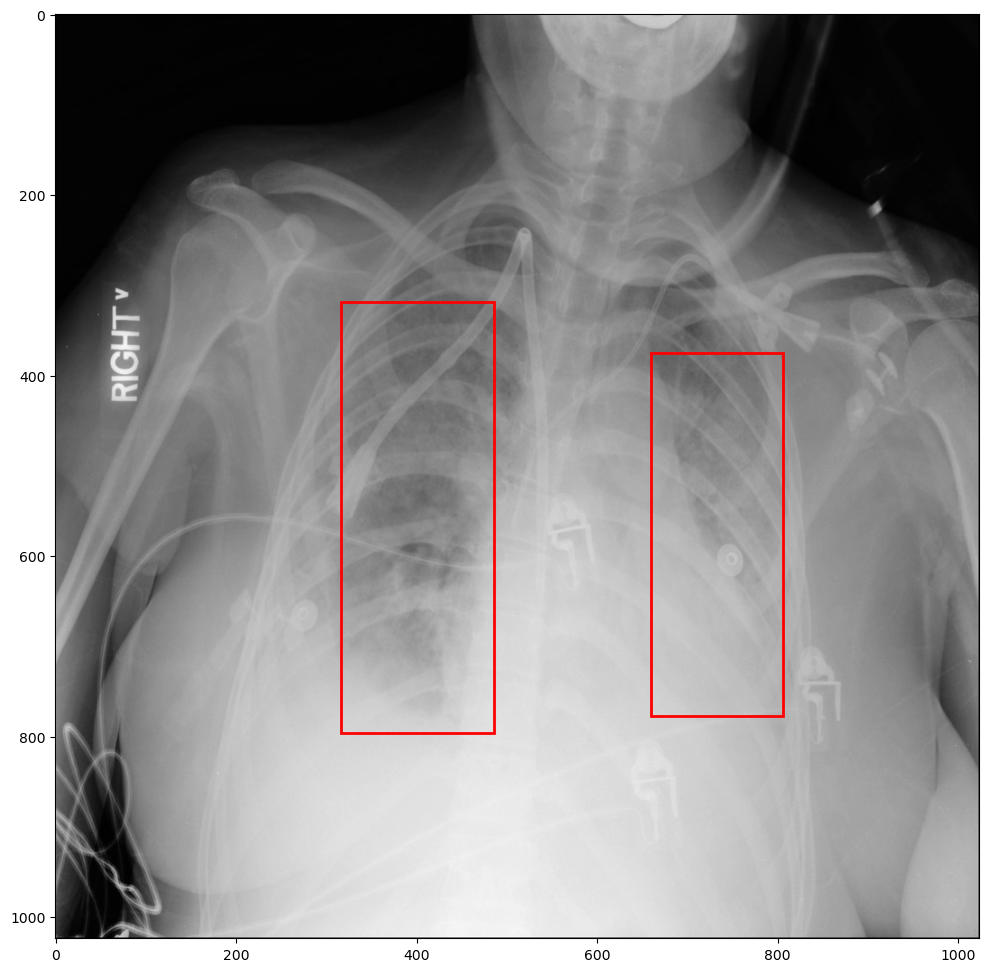

In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Lee la imagen PNG
imagen_path = '/home/jair/COVID/rsna/datasets/rsna1024/images/train/000db696-cf54-4385-b10b-6b16fbb3f985.png'
imagen = Image.open(imagen_path)

# Convierte la imagen a un arreglo NumPy
imagen_array = np.array(imagen)
bboxes=[[316.0, 318.0, 170.0, 478.0], [660.0, 375.0, 146.0, 402.0]]
fig, ax= plt.subplots(1, 1, figsize=(18, 12), facecolor='w', edgecolor='b')
for bb in bboxes:
    patch = ax.add_patch(patches.Rectangle((bb[0],bb[1]),bb[2],bb[3],fill=False,edgecolor='red',lw=2))
ax.imshow(imagen_array)

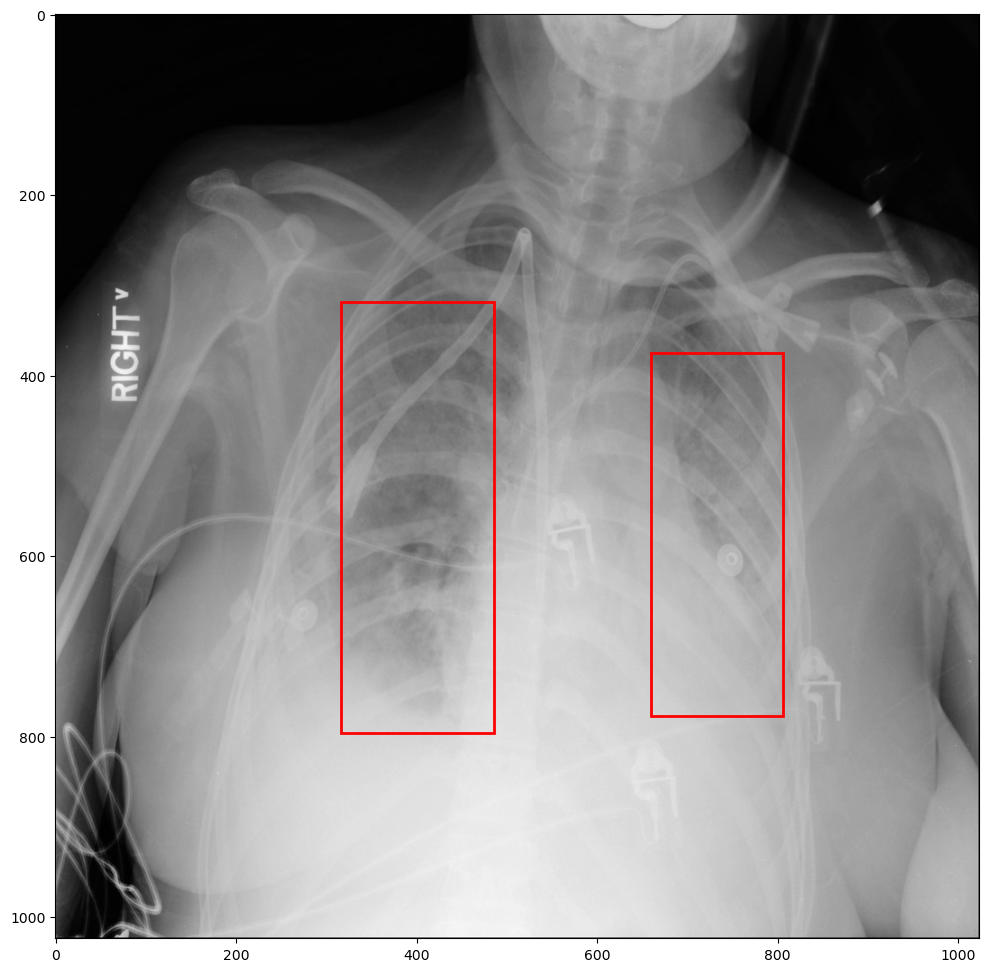

In [12]:
bboxes=[[0.3916015625*1024-0.166015625*1024/2, 0.5439453125*1024-0.466796875*1024/2, 0.166015625*1024, 0.466796875*1024],[0.7158203125*1024-0.142578125*1024/2, 0.5625*1024-0.392578125*1024/2, 0.142578125*1024, 0.392578125*1024]]
fig, ax= plt.subplots(1, 1, figsize=(18, 12), facecolor='w', edgecolor='b')
for bb in bboxes:
    patch = ax.add_patch(patches.Rectangle((bb[0],bb[1]),bb[2],bb[3],fill=False,edgecolor='red',lw=2))
ax.imshow(imagen_array)

<h1>RetinaNet</h1>

In [ ]:
import pandas as pd 
import numpy as np
from ast import literal_eval
import shutil
from tqdm import tqdm
import skimage 
import matplotlib.pyplot as plt
import os

In [ ]:
def yolon_to_xywh(bb,size):
    x=bb[0]*size-bb[2]*size/2
    y=bb[1]*size-bb[3]*size/2
    wp=bb[2]*size
    hp=bb[3]*size
    return [x, y, wp, hp]

In [ ]:
def crea_csv(tipo,size,dataset):
    O_doc=pd.read_csv("/home/jair/COVID/rsna/csv_crean_retina_dataset/"+tipo+"_opacity.csv")
    Opath=list(O_doc['rutas'])
    S_doc=pd.read_csv("/home/jair/COVID/rsna/csv_crean_retina_dataset/"+tipo+"_sanos.csv")
    Spath=list(S_doc['rutas'])
    todos=pd.read_csv("/home/jair/COVID/rsna/csv_crean_retina_dataset/class_opacity.csv")
    imgs=list(todos['patientId'])
    bbsn=list(todos["bboxes normalized"])
    df= pd.DataFrame(columns=["path","x1","y1","x2","y2","class"])
    pth=[]
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    cl=[]
    for path in Opath:
        name=path.split("/")[-1].replace(".png","")
        indx=imgs.index(name)
        bb=literal_eval(bbsn[indx])
        for box in bb:
            bbf=yolon_to_xywh(box,size)
            x1.append(int(bbf[0]))
            y1.append(int(bbf[1]))
            x2.append(int(bbf[0]+bbf[2]))
            y2.append(int(bbf[1]+bbf[3]))
            pth.append(path)
            cl.append('opacity')
    df['path']=pth
    df['x1']=x1
    df['y1']=y1
    df['x2']=x2
    df['y2']=y2
    df['class']=cl
    df.to_csv("/home/jair/COVID/rsna/"+dataset+"/"+tipo+"Ord"+str(size)+".csv",index=False)        

In [ ]:
tipo='validation'
size=1024
dataset='retina_opacity1024_csv'
crea_csv(tipo,size,dataset)

In [ ]:
#abre csv modificas agregando sanos nuevas anotaciones y ejecutas esto
train=pd.read_csv("/home/jair/COVID/rsna/"+dataset+"/"+tipo+"Ord"+str(size)+".csv")
trainr = train.sample(frac=1).reset_index(drop=True)
trainr.to_csv("/home/jair/COVID/rsna/"+dataset+"/"+tipo+str(size)+"RSNA.csv",index=False)

In [ ]:
#apartar crapeta solo de sanos para crear bboxes de pulmones sanos
modo='train'
rootd="/home/jair/COVID/rsna/datasets/sanos/images/"
doc=pd.read_csv("/home/jair/COVID/rsna/csv_crean_retina_dataset/"+modo+"_sanos.csv")
rutas=list(doc['rutas'])
for ruta in tqdm(rutas):
    shutil.copy(ruta, rootd)
    

In [ ]:
#codigo para modificar las clases de los txt generados 
tipo='validation'
Sdoc=pd.read_csv("/home/jair/COVID/rsna/csv_crean_retina_dataset/"+tipo+"_sanos.csv")
Spath=list(Sdoc['rutas'])

ro='/home/jair/COVID/rsna/datasets/sanos/labels individuals/'
rd='/home/jair/COVID/rsna/datasets/sanos/labels individuals/'+tipo+'/'

def replace_digits(line):
    return '1' + line[2:]

for ruta in tqdm(Spath):
    name=ruta.split('/')[-1].replace('png','txt')
    # Leer el archivo
    with open(ro+name, 'r') as f:
        lineas = f.readlines()
    # Modificar las líneas
    lineas_modificadas = [replace_digits(linea) for linea in lineas]
        
    # Escribir las líneas modificadas en el mismo archivo
    with open(rd+name, 'a') as f:
        f.writelines(lineas_modificadas)
        f.write('\n')   

In [ ]:
#generar etiquetado de toda la imagen
nueva_linea = '1 0.500781 0.500781 0.998437 0.998437\n'
tipo='validation'
Sdoc=pd.read_csv("/home/jair/COVID/rsna/csv_crean_retina_dataset/"+tipo+"_sanos.csv")
Spath=list(Sdoc['rutas'])

rd='/home/jair/COVID/rsna/datasets/sanos/labelsallimg/'+tipo+'/'

for ruta in tqdm(Spath):
    # Generar el nombre para el nuevo archivo
    name=ruta.split('/')[-1].replace('png','txt')
        
    # Escribir la nueva línea en el nuevo archivo
    with open(rd+name, 'w') as f:
        f.write(nueva_linea)   

In [ ]:
#crear df que contenga lista de bbox para yolo de pulmones individuales sanos para agregarlos a info del csv de sanos y poder generar antaciones de retinanet

Sdoc=pd.read_csv("/home/jair/COVID/rsna/csv_crean_retina_dataset/class_sano.csv")
Spath=list(Sdoc['id'])
ro='/home/jair/COVID/rsna/all/'
data = []

for name in tqdm(Spath):
    r=ro+name+'.txt'
    with open(r, 'r') as f:
        lines = f.readlines()
        numbers = [[float(num) for num in line.strip().split()[1:]] for line in lines]
        data.append(numbers)
        
df = pd.DataFrame({'id':Spath,'bbox_n_yolo':data})
df.to_csv('/home/jair/COVID/rsna/csv_crean_retina_dataset/class_sano_f.csv', index=False)

In [ ]:
# #crea csv para retinanet anotaciones de sanos con pulmones individuales

def crea_csv_ind(tipo,size,dataset):
    Odoc=pd.read_csv("/home/jair/COVID/rsna/csv_crean_retina_dataset/"+tipo+"_opacity.csv")
    Opath=list(Odoc['rutas'])
    Sdoc=pd.read_csv("/home/jair/COVID/rsna/csv_crean_retina_dataset/"+tipo+"_sanos.csv")
    Spath=list(Sdoc['rutas'])
    todoso=pd.read_csv("/home/jair/COVID/rsna/csv_crean_retina_dataset/class_opacity.csv")
    todoss=pd.read_csv("/home/jair/COVID/rsna/csv_crean_retina_dataset/class_sano.csv")
    imgo=list(todoso['patientId'])
    imgs=list(todoss['id'])
    bbsno=list(todoso["bboxes normalized"])
    bbsns=list(todoss["bbox_n_yolo"])
    df= pd.DataFrame(columns=["path","x1","y1","x2","y2","class"])
    pth=[]
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    cl=[]
    for path in Opath:
        name=path.split("/")[-1].replace(".png","")
        indx=imgo.index(name)
        bb=literal_eval(bbsno[indx])
        for box in bb:
            bbf=yolon_to_xywh(box,size)
            x1.append(int(bbf[0]))
            y1.append(int(bbf[1]))
            x2.append(int(bbf[0]+bbf[2]))
            y2.append(int(bbf[1]+bbf[3]))
            pth.append(path)
            cl.append('opacity')
    for path in Spath:
        name=path.split("/")[-1].replace(".png","")
        indx=imgs.index(name)
        bb=literal_eval(bbsns[indx])
        for box in bb:
            bbf=yolon_to_xywh(box,size)
            x1.append(int(bbf[0]))
            y1.append(int(bbf[1]))
            x2.append(int(bbf[0]+bbf[2]))
            y2.append(int(bbf[1]+bbf[3]))
            pth.append(path)
            cl.append('Noopacity')
    df['path']=pth
    df['x1']=x1
    df['y1']=y1
    df['x2']=x2
    df['y2']=y2
    df['class']=cl
    df.to_csv("/home/jair/COVID/rsna/"+dataset+"/"+tipo+"Ord"+str(size)+".csv",index=False)        

In [ ]:
tipo='validation'
size=640
dataset='retina_opacity_sano_ind640_csv'
crea_csv_ind(tipo,size,dataset)

In [ ]:
#revuelve documento
train=pd.read_csv("/home/jair/COVID/rsna/"+dataset+"/"+tipo+"Ord"+str(size)+".csv")
trainr = train.sample(frac=1).reset_index(drop=True)
trainr.to_csv("/home/jair/COVID/rsna/"+dataset+"/"+tipo+str(size)+"RSNA.csv",index=False)